<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_08_auto_ml_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML - Tuning

In [0]:
COLAB = True 

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_d2_v3'

In [0]:
# !pip install -U imblearn
# !pip install -U xgboost
# !pip install -U featuretools

In [38]:
if COLAB:
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects

Cloning into 'dl-projects'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 1674 (delta 30), reused 5 (delta 2), pack-reused 1625
Receiving objects: 100% (1674/1674), 76.22 MiB | 11.69 MiB/s, done.
Resolving deltas: 100% (1025/1025), done.


In [0]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .
  !cp dl-projects/plot* .

In [40]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math 
import matplotlib
import sys
import gc

from scipy import stats
from collections import Counter
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

import featuretools as ft
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, make_scorer, recall_score, roc_curve, mean_squared_error, accuracy_score, average_precision_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     AllKNN,
                                     NearMiss,
                                     OneSidedSelection)
from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced 
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN
import pylab as pl
import xgboost as xgb
from collections import Counter
from dateutil.relativedelta import relativedelta


# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer
# from scikitplot.plotters import plot_precision_recall_curve

from utils import feature_selection, plot_feature_importances
from preprocess import *
from plot import plot_correlation_matrix, plot_labeled_scatter

from IPython.display import display

np.set_printoptions(threshold=sys.maxsize)

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

In [42]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [43]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [44]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("../datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/f"{FEATURE_DATASET_PREFIX}.ft"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/DATASET_NAME

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M
  !ls -l dl-projects/datasets --block-size=M

total 6234M
-rw------- 1 root root 1548M Jan  7 00:07 feature_matrix_d2_v1.pkl
-rw------- 1 root root 2454M Jan 12 01:24 feature_matrix_d2_v2.ft
-rw------- 1 root root 1585M Jan 12 23:39 feature_matrix_d2_v3.ft
-rw------- 1 root root    5M Jan 30 04:33 orig_X_test.ft
-rw------- 1 root root  415M Jan 30 04:33 orig_X_train.ft
-rw------- 1 root root    1M Jan 30 04:33 orig_y_test.ft
-rw------- 1 root root    7M Jan 30 04:33 orig_y_train.ft
-rw------- 1 root root    3M Feb  7 11:23 test_X_test.ft
-rw------- 1 root root  213M Feb  7 11:23 test_X_train.ft
-rw------- 1 root root    1M Feb  7 11:23 test_y_test.ft
-rw------- 1 root root    7M Feb  7 11:23 test_y_train.ft
total 25M
-rw-r--r-- 1 root root  1M Feb  8 07:04 4D.zip
-rw-r--r-- 1 root root 25M Feb  8 07:04 labels.csv


In [0]:
# Read the data
data = pd.read_feather(DATASET)
origin_data = format_tabular(ORIGIN_DATASET)

## Exploratory Data Analysis

### View data

In [0]:
# Feature matrix
feature_matrix = data.drop(columns=['NumberId', 'month', 'year'])

In [47]:
# Sort data
feature_matrix.sort_values(by=['time', 'MAX(Results.LuckyNo)'], inplace=True)
feature_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 959893 entries, 7020 to 956511
Columns: 214 entries, time to LAST(Results.PrizeType)_Prize
dtypes: datetime64[ns](1), float64(155), int64(56), uint8(2)
memory usage: 1.5 GB


In [48]:
print('Distrbution')
print(feature_matrix['Label'].value_counts())
print()
print('Positive: ' + str(feature_matrix['Label'].value_counts()[0]) + ' which is ', round(feature_matrix['Label'].value_counts()[0]/len(feature_matrix) * 100,2), '% of the dataset')
print('Negative: ' + str(feature_matrix['Label'].value_counts()[1]) + ' which is ', round(feature_matrix['Label'].value_counts()[1]/len(feature_matrix) * 100,2), '% of the dataset')

Distrbution
0    927839
1     32054
Name: Label, dtype: int64

Positive: 927839 which is  96.66 % of the dataset
Negative: 32054 which is  3.34 % of the dataset


In [49]:
feature_matrix.isna().sum().sort_values(ascending=False)

SKEW(Results.TIME_SINCE_PREVIOUS(DrawDate))               7636
CUM_MEAN(TREND(Results.LuckyNo, DrawDate))                7636
TREND(Results.TIME_SINCE_PREVIOUS(DrawDate), DrawDate)    7636
TREND(Results.CUM_MEAN(TotalStrike), DrawDate)            7636
TREND(Results.CUM_SUM(LuckyNo), DrawDate)                 7636
                                                          ... 
CUM_SUM(MIN(Results.DrawNo))                                 0
NUM_UNIQUE(Results.DAY(DrawDate))                            0
NUM_UNIQUE(Results.MONTH(DrawDate))                          0
SUM(Results.PERCENTILE(LuckyNo))                             0
time                                                         0
Length: 214, dtype: int64

### Feature Selection

In [0]:
# Fill all NaN with 0
feature_matrix = feature_matrix.fillna(0)

In [51]:
feature_matrix.shape

(959893, 214)

In [52]:
feature_matrix_selection = feature_selection(feature_matrix.drop(columns = ['time', 'TotalStrike', 'Label']))

Original shape:  (959893, 211)
0 missing columns with threshold: 90.
41 zero variance columns.
109 collinear columns removed with threshold: 0.95.
Total columns removed:  150
Shape after feature selection: (959893, 61).


In [53]:
feature_matrix_selection.shape, feature_matrix_selection.columns

((959893, 61),
 Index(['STD(Results.DrawNo)', 'MAX(Results.DrawNo)', 'MAX(Results.LuckyNo)',
        'MIN(Results.DrawNo)', 'MEAN(Results.DrawNo)', 'SKEW(Results.DrawNo)',
        'AVG_TIME_BETWEEN(Results.DrawDate)', 'COUNT(Results)',
        'SUM(Results.DrawNo)', 'SUM(Results.LuckyNo)',
        'TREND(Results.DrawNo, DrawDate)', 'MONTH(first_Results_time)',
        'DAY(first_Results_time)', 'TIME_SINCE(first_Results_time)',
        'TIME_SINCE_PREVIOUS(first_Results_time)',
        'STD(Results.PERCENTILE(DrawNo))',
        'STD(Results.TIME_SINCE_PREVIOUS(DrawDate))',
        'STD(Results.CUM_SUM(DrawNo))', 'STD(Results.CUM_MEAN(LuckyNo))',
        'MAX(Results.PERCENTILE(DrawNo))',
        'MAX(Results.PERCENTILE(TotalStrike))',
        'MAX(Results.CUM_MEAN(LuckyNo))',
        'MIN(Results.TIME_SINCE_PREVIOUS(DrawDate))',
        'MIN(Results.CUM_MEAN(LuckyNo))', 'MODE(Results.MONTH(DrawDate))',
        'MODE(Results.DAY(DrawDate))', 'MEAN(Results.TIME_SINCE(DrawDate))',
       

In [0]:
feature_matrix_selection['time'] = feature_matrix['time']
feature_matrix_selection['TotalStrike'] = feature_matrix['TotalStrike']
feature_matrix_selection['Label'] = feature_matrix['Label']

### Feature Correlation

In [0]:
# Check with feature selection
corrs = feature_matrix_selection.corr().sort_values('Label')

In [56]:
corrs['Label'].tail(60)

STD(Results.CUM_SUM(DrawNo))                             -0.002778
MAX(Results.LuckyNo)                                     -0.002680
SUM(Results.LuckyNo)                                     -0.002426
MAX(Results.DrawNo)                                      -0.002377
MIN(Results.CUM_MEAN(LuckyNo))                           -0.002333
CUM_MEAN(AVG_TIME_BETWEEN(Results.DrawDate))             -0.002238
MEAN(Results.TIME_SINCE(DrawDate))                       -0.002056
STD(Results.PERCENTILE(DrawNo))                          -0.001937
PERCENTILE(STD(Results.LuckyNo))                         -0.001931
PERCENTILE(STD(Results.DrawNo))                          -0.001814
CUM_SUM(SKEW(Results.DrawNo))                            -0.001741
SUM(Results.TIME_SINCE(DrawDate))                        -0.001492
MEAN(Results.CUM_MEAN(LuckyNo))                          -0.001477
AVG_TIME_BETWEEN(Results.DrawDate)                       -0.001429
PERCENTILE(SKEW(Results.DrawNo))                         -0.00

## Modeling

In [0]:
def recall_optim(y_true, y_pred):
    """Make a scoring function that improves specificity while identifying all strikes
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Recall will be worth a greater value than specificity
    rec = recall_score(y_true, y_pred) * 0.8 
    spe = conf_matrix[0,0]/conf_matrix[0,:].sum() * 0.2 
    
    # Imperfect recalls will lose a penalty
    # This means the best results will have perfect recalls and compete for specificity
    if rec < 0.8:
        rec -= 0.2
    return rec + spe 


# Make a scoring callable from recall_score
recall = make_scorer(recall_score)

# Create a scoring callable based on the scoring function
optimize = make_scorer(recall_optim)

# DataFrame to store classifier performance
performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity', 'Optimize'])


def score_optimization(dt, feature_matrix, clf, params, X_train, y_train, X_test, y_test, skip_grid_search_cv=False, optimized_scorer=False):
    """Find the optimized classifier.
    """
    if not skip_grid_search_cv:
      print("\nFinding the optimized classifier...")

      # Load GridSearchCV
      # search = GridSearchCV(
      search = RandomizedSearchCV(
            estimator=clf,
            #param_grid=params,
            param_distributions=params,
            n_jobs=4,
            scoring=optimize  # Use custom scorer
      )

      # Train search object
      search.fit(X_train, y_train)

      # Heading
      print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)

      # Extract best estimator
      best = search.best_estimator_
      print('Best parameters: \n\n',search.best_params_,'\n')
    
    else:
      print("\nUse the passed in classifier...\n")
      best = clf

    # Cross-validate on the train data
    print("TRAIN GROUP")
    #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    cv = 3
    if not optimized_scorer:
      print('\nUse default scorer')
      train_cv = cross_val_score(
                                n_jobs=4,
                                X=X_train, 
                                y=y_train, 
                                estimator=best, 
                                scoring=recall,
                                cv=cv)
    else:
      print('\nUse optimized scorer')
      train_cv = cross_val_score(
                                n_jobs=4,
                                X=X_train, 
                                y=y_train, 
                                estimator=best, 
                                #scoring=optimize,
                                scoring='roc_auc',
                                cv=cv)

    print("\nCross-validation recall scores:",train_cv)
    print("Mean recall score:",train_cv.mean())

    # Now predict on the test group
    print("\nTEST GROUP")
    y_pred = best.fit(X_train, y_train).predict(X_test)
    probas = best.predict_proba(X_test)[:, 1]
    print("\nRecall:",recall_score(y_test,y_pred))

    # Get imbalanced classification report
    print(classification_report_imbalanced(y_test, y_pred))

    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test,y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()

    # Store results
    performance.loc[clf.__class__.__name__+'_optimize',:] = [
        train_cv.mean(),
        recall_score(y_test,y_pred),
        conf_matrix[0,0]/conf_matrix[0,:].sum(),
        recall_optim(y_test,y_pred)
    ]
    # Look at the parameters for the top best scores
    if not skip_grid_search_cv:
      display(pd.DataFrame(search.cv_results_).iloc[:,4:].sort_values(by='rank_test_score').head())
    display(performance)

    # Additionl info
    print('\n\nAdditional Info')
    print('='*40)
    positive = np.where((y_pred==1))
    print(f'Total predicted to be positive: {len(positive[0])} \n')

    # Total predicted matches
    print('Predicted matches')
    pred = np.where((y_pred==1))
    print(len(pred[0]), pred[0][0:23])
    topN = np.argpartition(probas, -23)[-23:]
    print(f'\n{topN}\n')  # Top N most high probability numbers
  
    if len(positive[0]) > 0:
    
      # Matching draws
      print('Matched draws')
      md = np.where((y_pred==1) & (y_test==1))
      print(f"Count: {len(md[0])}, Index: {md}")
      month_data = feature_matrix.loc[feature_matrix['time'] == dt]
      numbers = month_data.iloc[md[0]][['MAX(Results.LuckyNo)']]

      print('\n\nTop 23 Possibility')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(topN))].head(23))  
      
      print('\n\nFirst 23 Numbers')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(pred[0][0:23]))].head(23))    
             

      print('\n\nAll matched')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(numbers['MAX(Results.LuckyNo)']))].head(100))    
                                                  
    else:
      print('No luck this month')  
  

In [0]:
def remove_outliers(balanced, threshold=0.001, remove=True):
    """Removing Outliers from high-correlation features.
    """

    if not remove:
      return balanced

    bal_corr = balanced.corr()
    no_outliers=pd.DataFrame(balanced.copy())

    cols = bal_corr.Label.index[:-1]

    # For each feature correlated with Class...
    for col in cols:
        # If absolute correlation value is more than X percent...
        correlation = bal_corr.loc['Label',col]

        if np.absolute(correlation) > threshold:
          # Separate the classes of the high-correlation column
          nonstrikes = no_outliers.loc[no_outliers.Label==0,col]
          strikes = no_outliers.loc[no_outliers.Label==1,col]

          # Identify the 25th and 75th quartiles
          all_values = no_outliers.loc[:,col]
          q25, q75 = np.percentile(all_values, 25), np.percentile(all_values, 75)
          # Get the inter quartile range
          iqr = q75 - q25
          # Smaller cutoffs will remove more outliers
          cutoff = iqr * 7
          # Set the bounds of the desired portion to keep
          lower, upper = q25 - cutoff, q75 + cutoff
          
          # If positively correlated...
          # Drop nonstrikes above upper bound, and strikes below lower bound
          if correlation > 0: 
              no_outliers.drop(index=nonstrikes[nonstrikes>upper].index,inplace=True)
              no_outliers.drop(index=strikes[strikes<lower].index,inplace=True)
          
          # If negatively correlated...
          # Drop non strikes below lower bound, and strikes above upper bound
          elif correlation < 0: 
              no_outliers.drop(index=nonstrikes[nonstrikes<lower].index,inplace=True)
              no_outliers.drop(index=strikes[strikes>upper].index,inplace=True)
        
    print('\nData shape before removing outliers:', balanced.shape)
    print('\nCounts of strikes VS non-strikes in previous data:')
    print(balanced.Label.value_counts())
    print('-'*40)
    print('-'*40)
    print('\nData shape after removing outliers:', no_outliers.shape)
    print('\nCounts of strikes VS non-strikes in new data:')
    print(no_outliers.Label.value_counts())

    # no_outliers.iloc[:,:-1].boxplot(rot=90,figsize=(16,4))
    # plt.title('Distributions with Less Outliers', fontsize=17)
    # plt.show()
    
    no_outliers.reset_index(drop=True, inplace=True)
    return no_outliers


def filter_features(no_outliers, threshold=0.001):
    """Feature selection.
    """
    feat_sel = pd.DataFrame(no_outliers.copy())

    # Make a dataframe with the label-correlations before removing outliers
    # corr_change = pd.DataFrame()
    # corr_change['correlation']= bal_corr.Label
    # corr_change['origin']= 'w/outliers'

    # Make a dataframe with label-correlations after removing outliers 
    # corr_other = pd.DataFrame()
    # corr_other['correlation']= feat_sel.corr().Label
    # corr_other['origin']= 'no_outliers'

    # Join them
    # corr_change = corr_change.append(corr_other)

    # plt.figure(figsize=(14,6))
    # plt.xticks(rotation=90)

    # Plot them
    # sns.set_style('darkgrid')
    # plt.title('Label correlation per feature. With vs without outliers', fontsize=17)
    # sns.barplot(data=corr_change,x=corr_change.index,y='correlation',hue='origin')
    # plt.show()

    # Feature Selection based on correlation with label

    print('\nData shape before feature selection:', feat_sel.shape)
    print('\nCounts of strikes vs non-strikes before feature selection:')
    print(feat_sel.Label.value_counts())
    print('-'*40)

    # Correlation matrix after removing outliers
    new_corr = feat_sel.corr()

    for col in new_corr.Label.index[:-1]:
        # Pick desired cutoff for dropping features. In absolute-value terms.
        if np.absolute(new_corr.loc['Label',col]) < threshold:
            # Drop the feature if correlation is below cutoff
            feat_sel.drop(columns=col,inplace=True)

    print('-'*40)
    print('\nData shape after feature selection:', feat_sel.shape)
    print('\nCounts of strikes vs non-strikes in new data:')
    print(feat_sel.Label.value_counts())

    return feat_sel

    # feat_sel.iloc[:,:-1].boxplot(rot=90,figsize=(16,4))
    # plt.title('Distribution of Features Selected', fontsize=17)
    # plt.show()

def under_sampler(data, sample_size=20000, sampling=False):
    # Undersample model for efficiency and balance classes.

    X_train = data.drop('Label',1)
    y_train = data.Label

    if not sampling:
      return X_train, y_train

    # After feature-selection, X_test needs to include only the same features as X_train
    # cols = X_train.columns
    # X_test = X_test[cols]

    # Undersample and balance classes
    X_train, y_train = RandomUnderSampler(sampling_strategy={1:sample_size,0:sample_size}).fit_resample(X_train,y_train)

    print('\nX_train shape after reduction:', X_train.shape)
    print('\nCounts of strikes VS non-strikes in y_train:')
    print(np.unique(y_train, return_counts=True))

    return X_train, y_train

In [0]:
def gen_train_test_set(dt, feature_matrix, file_prefix='data'): 
    
    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['time'] == dt, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['time'] < dt, 'Label']

    # Features
    X_train = feature_matrix[feature_matrix['time'] < dt].drop(columns = ['NumberId', 'time', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    X_test = feature_matrix[feature_matrix['time'] == dt].drop(columns = ['NumberId', 'time', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    feature_names = list(X_train.columns)
    
    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))

    # Join the train data
    train = X_train.join(train_labels)

    print('Data shape before balancing:', train.shape)
    print('\nCounts of strikes vs non-strikes in previous data:')
    print(train.Label.value_counts())
    print('-'*40)

    # sklearn pipeline
    pipeline = make_pipeline(
        SimpleImputer(strategy = 'constant', fill_value=0),
        StandardScaler())
    
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)

    # imblearn pipeline
    imb_pipeline = make_pipeline_imb(
          NearMiss(version=3, n_neighbors_ver3=3, n_jobs=4)
          # SMOTE(sampling_strategy='minority',random_state=42, n_jobs=4)
          #OneSidedSelection(n_neighbors=1, n_seeds_S=200, random_state=42, n_jobs=4)
    )
     
    # Balance the data
    to_balanced = False
    if to_balanced:
      print('\nBalancing data')
      X_bal, y_bal = imb_pipeline.fit_resample(X_train, y_train)
      X_bal = pd.DataFrame(X_bal,columns=feature_names)
      y_bal = pd.DataFrame(y_bal,columns=['Label'])
    else:
      print('\nNO balancing')
      X_bal = pd.DataFrame(X_train,columns=feature_names)
      y_bal = pd.DataFrame(y_train,columns=['Label'])

    balanced = X_bal.join(y_bal)

    # print('-'*40)
    print('Data shape after balancing:',balanced.shape)
    print('\nCounts of strikes VS non-strikes in new data:')
    print(balanced.Label.value_counts())

    # Remove high correlation outliers
    no_outliers = remove_outliers(balanced, remove=True)
   
    # Remove features with low correlation
    remove_features = True
    if remove_features:
      print('\nFiltering features')
      features_selected = filter_features(no_outliers)
    else:
      print('\nNO filtering')
      features_selected = no_outliers 

    columns_selected = features_selected.drop('Label',1).columns

    # Under sampling
    X_train, y_train = under_sampler(features_selected, sampling=False) 
    X_train = pd.DataFrame(X_train,columns=columns_selected)
    y_train = pd.DataFrame(y_train,columns=['Label'])

    # For X_test, now only use the selected features
    X_test = pd.DataFrame(X_test,columns=feature_names)
    X_test = X_test[columns_selected]
    y_test = pd.DataFrame(y_test,columns=['Label'])

    #print(X_train.describe())
    #return

    # Save data
    # print(X_train.head(10))
    # print(y_train.head(10)) 

    # print(X_test.head(10))
    # print(y_test.head(10)) 
    X_train.to_feather(DATASET_PATH/f"{file_prefix}_X_train.ft")
    y_train.to_feather(DATASET_PATH/f"{file_prefix}_y_train.ft")
   
    X_test.to_feather(DATASET_PATH/f"{file_prefix}_X_test.ft")
    y_test.to_feather(DATASET_PATH/f"{file_prefix}_y_test.ft")

    gc.collect()


In [0]:
def model(dt, feature_matrix, file_prefix='data', csv=False):
    """Predict for a particular month.

    - https://www.kaggle.com/miguelniblock/optimizing-imbalanced-classification-100-recall
    - https://www.kaggle.com/saxinou/imbalanced-data-xgboost-tunning
    - https://www.kaggle.com/andreanuzzo/balance-the-imbalanced-rf-and-xgboost-with-smote
    - https://github.com/mengwangk/FraudDetection/blob/master/05_Sampling_techniques_for_extremely_imbalanced_data.ipynb
    - https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
    - https://github.com/coding-maniacs/over-under-sampling/blob/master/src/main.py
    - https://github.com/scikit-learn-contrib/imbalanced-learn/issues/552#issuecomment-466348310
    - https://stackoverflow.com/questions/52499788/smotetomek-how-to-set-ratio-as-dictionary-for-fixed-balance
    - https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.OneSidedSelection.html#imblearn.under_sampling.OneSidedSelection
    - https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
    - https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/
    - https://seaborn.pydata.org/generated/seaborn.heatmap.html
    - https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets
    - https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html#sphx-glr-auto-examples-svm-plot-oneclass-py
    - https://machinelearningmastery.com/cost-sensitive-logistic-regression/
    
    - https://datascience.stackexchange.com/questions/28285/what-is-the-best-way-to-deal-with-imbalanced-data-for-xgboost/28292
    - https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
    - https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
    
    """

    # Read data
    if not csv:
      X_train = pd.read_feather(DATASET_PATH/f"{file_prefix}_X_train.ft")
      y_train = pd.read_feather(DATASET_PATH/f"{file_prefix}_y_train.ft")
    
      X_test = pd.read_feather(DATASET_PATH/f"{file_prefix}_X_test.ft")
      y_test = pd.read_feather(DATASET_PATH/f"{file_prefix}_y_test.ft")
    else:
      X_train = pd.read_csv(DATASET_PATH/f"{file_prefix}_X_train.csv", header=0, sep=',', quotechar='"')
      y_train = pd.read_csv(DATASET_PATH/f"{file_prefix}_y_train.csv", header=0, sep=',', quotechar='"')
    
      X_test = pd.read_csv(DATASET_PATH/f"{file_prefix}_X_test.csv", header=0, sep=',', quotechar='"')
      y_test = pd.read_csv(DATASET_PATH/f"{file_prefix}_y_test.csv", header=0, sep=',', quotechar='"')

    # Reshape
    y_train = np.array(y_train).reshape((-1, ))
    y_test = np.array(y_test).reshape((-1, ))
    
    print('Data shape')
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    # print(X_train.describe())
    # return

    # Calculate hit ratio for xgboost classifier
    print("\nCalculating scale pos weight")
    counter = Counter(y_train)
    print(Counter(y_train))
    scale_pos_weight = float(counter[0] / counter[1])
    print(f"\nscale_pos_weight - {scale_pos_weight}\n")
    
     # Modeling
#     clf = xgb.XGBClassifier(
#               n_jobs=4, 
#               random_state=42,
#               #learning_rate=0.1,
#               #n_estimators=500,
#               #max_depth=6, 
#               #min_child_weight=3, 
#               #gamma=0,
#               #subsample=0.8,
#               #colsample_bytree=0.8,
#               objective='binary:logistic', 
#               scale_pos_weight=scale_pos_weight,
#               ##eval_metric="auc",
#               ##max_delta_step=1,
#               seed=27)
#     clf = xgb.XGBClassifier(n_jobs=4, 
#                             random_state=42,
#                             objective='binary:logistic', 
#                             #scale_pos_weight=28)
#                             scale_pos_weight=scale_pos_weight)
    
    clf = xgb.XGBClassifier(
                    n_jobs=4, 
                    random_state=42,
                    objective='binary:logistic',
                    subsample=0.55, 
                    n_estimators=300,
                    #n_estimators=400,
                    min_child_weight=1,
                    max_depth=3, 
                    learning_rate=0.007,
                    gamma=0.1, 
                    colsample_bytree=0.95,
                    tree_method='hist',
                    #booster='dart',
                    scale_pos_weight=scale_pos_weight
                    )

    clf_params = clf.get_params()
    print(clf_params)

    # Set parameters
    #clf_params['max_depth'] = 10
    #clf.set_params(clf_params)

    # Parameters to compare
    weights = [i for i in range(1,36,1)]
    weights.append(scale_pos_weight)
    learn_params = {
        'n_estimators': [100, 300, 500, 800, 1000], 
        'max_depth': range(3,10,2),
        'min_child_weight': range(1,6,2),
        #'gamma':[i/10.0 for i in range(0,5)],
        'subsample':[i/100.0 for i in range(55,70,5)],
        'colsample_bytree':[i/100.0 for i in range(85,100,5)],
        #'learning_rate':[i/1000.0 for i in range(5,20,2)],
        'scale_pos_weight': weights
    }
    print(f'Parameter distribution: {learn_params}')
    
    # Test and validate
    score_optimization(dt,
                       feature_matrix,
                       clf, 
                       learn_params,  
                       X_train, 
                       y_train, 
                       X_test, 
                       y_test, 
                       skip_grid_search_cv=True,
                       optimized_scorer=True)

    gc.collect()
    
    # clf.fit(X_train, y_train)
    # y_pred = clf.predict(X_test)

    # # ROC score
    # auc = roc_auc_score(y_test, y_pred)
    # print("ROC score: ", auc)

    # # Print confusion matrix
    # conf_matrix = confusion_matrix(y_test, y_pred)
    # sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
    # plt.show()

    # Parameters to compare
    # params = {
    #     'criterion':['entropy','gini'],
    #     'class_weight':[{1:1,0:0.3},{1:1,0:0.4},{1:1,0:0.5},{1:1,0:0.6},{1:1,0:7}]
    # }

    # Implement the classifier
    # clf = RandomForestClassifier(
    #     n_estimators=100,
    #     max_features=None,
    #     n_jobs=4,
    # )

    # # Test and validate
    # score_optimization(clf, params, X_train, y_train, X_test, y_test)

In [0]:
# Predict for a particular month
# %time predict(pd.datetime(2019,6,1), feature_matrix_selection)

# %time gen_train_test_set(pd.datetime(2019,6,1), feature_matrix_selection)

# %time gen_train_test_set(pd.datetime(2019,6,1), feature_matrix_selection, file_prefix='test')

# %time model(pd.datetime(2019,6,1), feature_matrix_selection, file_prefix='orig')


2019-06-01 00:00:00
-------------------

Training on 889893 observations.
Testing on 10000 observations.

Data shape before balancing: (889893, 62)

Counts of strikes vs non-strikes in previous data:
0    860060
1     29833
Name: Label, dtype: int64
----------------------------------------

NO balancing
Data shape after balancing: (889893, 62)

Counts of strikes VS non-strikes in new data:
0    860060
1     29833
Name: Label, dtype: int64

Data shape before removing outliers: (889893, 62)

Counts of strikes VS non-strikes in previous data:
0    860060
1     29833
Name: Label, dtype: int64
----------------------------------------
----------------------------------------

Data shape after removing outliers: (770675, 62)

Counts of strikes VS non-strikes in new data:
0    741374
1     29301
Name: Label, dtype: int64

Filtering features

Data shape before feature selection: (770675, 62)

Counts of strikes vs non-strikes before feature selection:
0    741374
1     29301
Name: Label, dtype:

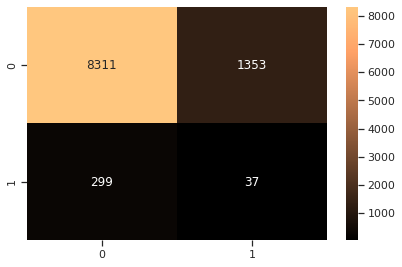

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.565812,0.110119,0.859996,0.0600944




Additional Info
Total predicted to be positive: 1390 

Predicted matches
1390 [ 11  19  23  25  31  32  39  41  51  53  55  61  63  65  81  86  87  93
  97  99 100 110 114]

[1042 4292  588 3423 1038 2404 9927 6358 3209 4473 1601  380 9103 2396
 7444 3491 8153 3569 5261 6649 6740 6799 2831]

Matched draws
Count: 37, Index: (array([  87,  786, 1111, 1144, 1199, 1218, 1359, 1693, 1753, 2089, 2512,
       2663, 2835, 2837, 2885, 2965, 3040, 3840, 3876, 4150, 4591, 4668,
       4738, 4939, 5612, 6022, 7327, 7394, 7425, 7801, 7882, 8146, 8148,
       8178, 8389, 9410, 9927]),)


Top 23 Possibility
        DrawNo   DrawDate       PrizeType  LuckyNo
104616  495619 2019-06-05  ConsolationNo9     9927


First 23 Numbers
        DrawNo   DrawDate       PrizeType  LuckyNo
104777  496319 2019-06-19  ConsolationNo9       87


All matched
        DrawNo   DrawDate        PrizeType  LuckyNo
104558  495419 2019-06-01       1stPrizeNo     7882
104565  495419 2019-06-01   ConsolationNo4     2089
10457

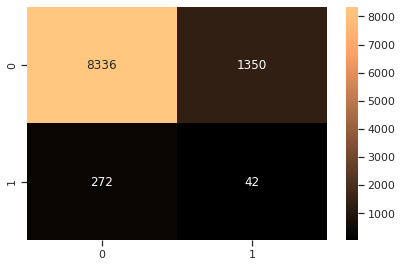

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.56699,0.133758,0.860624,0.0791311




Additional Info
Total predicted to be positive: 1392 

Predicted matches
1392 [ 11  19  23  25  31  32  39  41  51  53  55  61  63  65  81  86  87  93
  97  99 100 110 114]

[8408 8567 3491 2892 9423 1251 1601 6881 3569 2831 4087 8625 1553 4796
 1042 6960 1811 1297 2404 2396 2114 5261 3861]

Matched draws
Count: 42, Index: (array([ 162,  395,  407,  509,  719, 1110, 1507, 1561, 1965, 2094, 2116,
       2255, 2327, 2809, 3075, 3309, 3391, 3777, 4468, 4497, 4589, 5045,
       5612, 5981, 6044, 6175, 6190, 6274, 6308, 6683, 6970, 7083, 7292,
       7410, 7610, 8267, 8492, 8867, 9135, 9299, 9398, 9799]),)


Top 23 Possibility
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


First 23 Numbers
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


All matched
        DrawNo   DrawDate        PrizeType  LuckyNo
104903  496919 2019-07-03       1stPrizeNo     6175
104904  496919 2019-07-03       2ndPrizeNo     2809
104913  496919 2019-07-03   Con

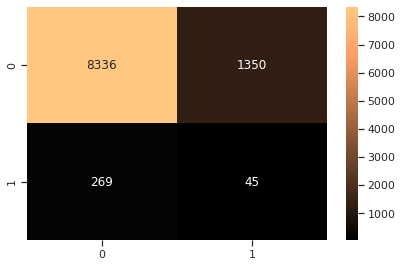

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.565102,0.143312,0.860624,0.0867744




Additional Info
Total predicted to be positive: 1395 

Predicted matches
1395 [ 11  19  23  25  31  32  39  41  51  53  55  61  63  65  81  86  87  93
  97  99 100 110 114]

[2892 5261 1042 3569 6799 1811 8408  118  380 4332 1710 4346 1601 8567
 3423 4950 8625 4473 1297 8822 1251 7125 6098]

Matched draws
Count: 45, Index: (array([ 213,  380,  584,  668,  738, 1162, 1202, 1601, 1856, 2693, 2813,
       2827, 2847, 3105, 3443, 3871, 4583, 5239, 5378, 5704, 5850, 6114,
       6190, 6235, 6634, 6691, 7083, 7145, 7241, 7292, 7643, 7748, 7760,
       7838, 7889, 8320, 8899, 8997, 9204, 9335, 9429, 9610, 9837, 9865,
       9993]),)


Top 23 Possibility
        DrawNo   DrawDate   PrizeType  LuckyNo
105311  498619 2019-08-10  SpecialNo4      380
105402  499019 2019-08-18  SpecialNo3     1601


First 23 Numbers
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


All matched
        DrawNo   DrawDate        PrizeType  LuckyNo
105230  498319 2019-08-03   ConsolationNo2 

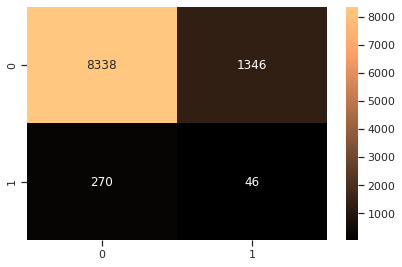

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.564884,0.14557,0.861008,0.0886573




Additional Info
Total predicted to be positive: 1392 

Predicted matches
1392 [ 11  19  23  25  31  32  39  41  51  53  55  61  63  65  81  86  87  93
  97  99 100 110 114]

[2759 3548 9927 4077 4916 6520  419 3434 3438 9098 5192  428 5154 3115
 4888 6660   99 7568 8999  448 9763 5617 7418]

Matched draws
Count: 46, Index: (array([  53,  358,  420,  905, 1234, 1485, 2277, 2867, 2937, 2948, 3181,
       3314, 3576, 3591, 3757, 3775, 3826, 3901, 3979, 4158, 4230, 4306,
       4323, 4476, 4620, 4751, 5083, 5162, 5550, 5569, 6284, 6346, 6468,
       7017, 7140, 7151, 7316, 7469, 7588, 7634, 7934, 8981, 9049, 9559,
       9763, 9865]),)


Top 23 Possibility
        DrawNo   DrawDate       PrizeType  LuckyNo
105738  500519 2019-09-18  ConsolationNo4     9763


First 23 Numbers
        DrawNo   DrawDate   PrizeType  LuckyNo
105769  500619 2019-09-21  SpecialNo2       53


All matched
        DrawNo   DrawDate        PrizeType  LuckyNo
105574  499819 2019-09-04  ConsolationNo10     4306
1055

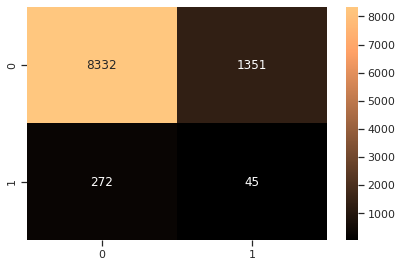

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.567458,0.141956,0.860477,0.0856601




Additional Info
Total predicted to be positive: 1396 

Predicted matches
1396 [ 11  19  23  25  31  32  39  41  51  53  55  61  63  65  81  86  87  93
  97  99 100 110 114]

[4025 9096 5301 3515 8355 2752 5282 9103 3362 6114 1553  156 7227 1949
 6649 7517 9076  982 5311 6446 8320 5999 4473]

Matched draws
Count: 45, Index: (array([  31,  364,  823,  998, 1359, 1372, 2227, 2330, 2917, 3049, 3399,
       3713, 3794, 3802, 3876, 3882, 4060, 4165, 4296, 4501, 4701, 4791,
       4809, 5242, 5378, 5625, 5652, 5774, 6080, 6460, 6649, 6935, 7344,
       7704, 8267, 8660, 8726, 8761, 8909, 8998, 9039, 9240, 9661, 9691,
       9727]),)


Top 23 Possibility
        DrawNo   DrawDate       PrizeType  LuckyNo
106018  501719 2019-10-13  ConsolationNo8     6649


First 23 Numbers
        DrawNo   DrawDate   PrizeType  LuckyNo
106181  502419 2019-10-30  SpecialNo1       31


All matched
        DrawNo   DrawDate       PrizeType  LuckyNo
105869  501119 2019-10-01      1stPrizeNo     7344
105883  5011

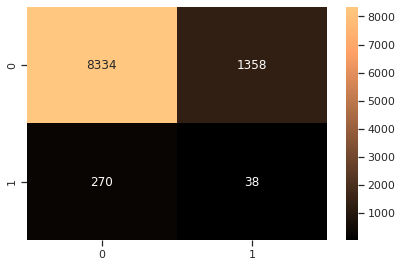

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.565005,0.123377,0.859884,0.0706782




Additional Info
Total predicted to be positive: 1396 

Predicted matches
1396 [ 11  19  23  25  31  32  39  41  51  53  55  61  63  65  81  86  87  93
  97  99 100 110 114]

[ 758 6152 8716 9379 9482 7363 8638 3751 5117   65  932 7034 3434 5314
 9593  114 6649 7165 9173 8912 6833 6660 9398]

Matched draws
Count: 38, Index: (array([  51,  584, 1183, 1352, 1898, 2649, 2759, 2911, 2961, 3238, 3515,
       3583, 3778, 4465, 4572, 4939, 5126, 5690, 5748, 6151, 6305, 6440,
       6618, 6691, 7083, 7181, 7363, 7444, 7517, 7934, 8015, 8325, 8427,
       8504, 8585, 8946, 9841, 9846]),)


Top 23 Possibility
        DrawNo   DrawDate       PrizeType  LuckyNo
106272  502819 2019-11-06  ConsolationNo9     7363


First 23 Numbers
        DrawNo   DrawDate    PrizeType  LuckyNo
106297  502919 2019-11-09  SpecialNo10       51


All matched
        DrawNo   DrawDate        PrizeType  LuckyNo
106195  502519 2019-11-02  ConsolationNo10     1352
106198  502519 2019-11-02   ConsolationNo4     9846
10620

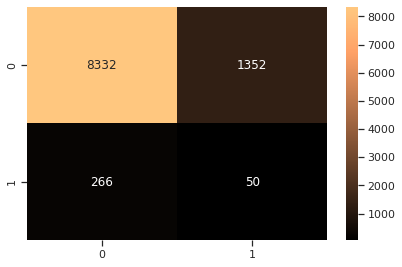

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.564034,0.158228,0.860388,0.0986599




Additional Info
Total predicted to be positive: 1402 

Predicted matches
1402 [ 11  19  23  25  31  32  39  41  51  53  55  61  63  65  81  86  87  93
  97  99 100 110 114]

[ 588  950  933 4473 6358 9258 6960  592 2396 2892 8981 2404 6098 7455
 7791 8822 1251 1038 8567 1710  155 3114 5261]

Matched draws
Count: 50, Index: (array([ 153,  155,  545,  572,  876,  920, 1082, 1368, 1401, 1438, 1443,
       1514, 1532, 1833, 2398, 2440, 2519, 2768, 2885, 2965, 3049, 3176,
       3185, 3921, 3972, 3977, 4171, 4381, 4388, 4429, 4551, 4767, 5046,
       5393, 5711, 5889, 7031, 7323, 7365, 7369, 7385, 7425, 7461, 8119,
       8216, 8250, 9239, 9428, 9433, 9989]),)


Top 23 Possibility
        DrawNo   DrawDate   PrizeType  LuckyNo
106694  504619 2019-12-15  SpecialNo7      155


First 23 Numbers
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


All matched
        DrawNo   DrawDate        PrizeType  LuckyNo
106515  503919 2019-12-01       3rdPrizeNo     5711
106525  

In [62]:
# n_estimators = 300
# remove outliers
# filter features
start_mt = pd.datetime(2019,6,1)
how_many_mt = 7 
for i in range(how_many_mt):
  month_to_predict = start_mt + relativedelta(months=i)
  print(f"\n{month_to_predict}\n-------------------\n")
  %time gen_train_test_set(month_to_predict, feature_matrix_selection, file_prefix='test')
  %time model(month_to_predict, feature_matrix_selection, file_prefix='test')